In [2]:
import numpy as np
import pandas as pd
from scipy.io import loadmat, mmread
import sys
import itertools 
import pickle
import matplotlib.pylab as plt
import time

In [3]:
%matplotlib inline

In [19]:
import rankingmethod
import rankingmeasure

In [6]:
%load_ext autoreload
%autoreload 2

In [5]:
from experiment import *

# Epinion

In [20]:
data = pd.read_csv("../datasets/soc-Epinions1.txt", sep='\t', header=4)
data = data.as_matrix()

In [ ]:
#создание epinion удалив от туда пользователей, у которых количество отзывов меньше 25
#Также проводится переиндексанция пользователей и предметов

In [21]:
epinion, user_item = make_valid_data(data)

In [22]:
train, test, traintest = givenK_train_test(epinion, 5)

In [45]:
poprec = rankingmethod.PopRec(user_item)
poprec.fit(train)
top = poprec.get_list(0)[:3]
# all_measures(train, test, poprec, True, top)
all_measures(train, test, poprec, True)

precK 0.200090805902
1-call5 0.5704880817253122
MRR 0.4442181549069617
AUC 0.82976857585
NGDC 0.224440369342
MAP 0.387606570816


In [ ]:
###CLimf подбор параметров(не используя фичу авторов)

In [ ]:
list_reg = [0.001, 0.05, 0.01, 0.005 , 0.001]
list_lrate = [0.01, 0.0001, 0.005, 0.01, 0.05, 0.1 ]
list_K = [10, 5, 7, 12, 15]

climf_validation = np.zeros((len(list_reg), len(list_lrate), len(list_K)))

for i, K in enumerate(list_K):
    for j, lrate in enumerate(list_lrate):
        for m, reg in enumerate(list_reg):
            climf = rankingmethod.CLiMF(user_item,K=K, reg=reg, lrate=lrate, verbose=0, maxiter=10)
            climf.fit(train)
            mrr = rankingmeasure.get_MRR(train, test, 
            climf, skip_train=False)
            climf_validation[i,j,m] = mrr
            print(K, lrate, reg, "MRR", mrr)
            sys.stdout.flush()

###проверка работы авторского решения

In [77]:
create_csr(train, user_item, 'another_train.mtx')
create_csr(test, user_item, 'another_test.mtx')

###BPR_MF Подбор параметров

In [ ]:
list_reg = [0.01, 0.05, 0.1, 0.2]
list_lrate = [0.0001, 0.001, 0.005]
list_K = [10, 15,  20]

bpr_mf_validation = np.zeros((len(list_K), len(list_lrate), len(list_reg)))

for i, K in enumerate(list_K):
    for j, lrate in enumerate(list_lrate):
        for m, reg in enumerate(list_reg):
            cf = rankingmethod.BPR_MF(user_item,K=K, regU=reg, regIpos=reg, regIneg=reg, 
                                      lrate=lrate, verbose=0, maxiter=30)
            cf.fit(train)
            res = rankingmeasure.get_AUC(train, test, cf)
            bpr_mf_validation[i,j,m] = res
            print(K, lrate, reg, "AUC", res)
            sys.stdout.flush()

In [ ]:
with open('bpr_mf_validation.pickle', 'wb') as f:
    f.dump(bpr_mf_validation, f)

###iMF Подбор  параметров

In [ ]:
list_alpha = [10, 20, 40, 80]
list_lmbd = [0.001, 0.01, 0.05, 0.1]
list_K = [10, 15,  20]

imf_validation = np.zeros((len(list_K), len(list_alpha), len(list_lmbd)))

for i, K in enumerate(list_K):
    for j, alpha in enumerate(list_alpha):
        for m, lmbd in enumerate(list_lmbd):
            cf = rankingmethod.iMF(user_item, K=K, lmbd=lmbd, alpha=alpha, maxiter=30, verbose=0)
            cf.fit(train)
            mrr = rankingmeasure.get_prec_K(train, test, cf)
            imf_validation[i,j,m] = mrr
            print(K, lrate, reg, "prec", mrr)
            sys.stdout.flush()

In [54]:
cf = rankingmethod.TFMAP(user_item, lrate=0.01, verbose = 3, maxiter=9)
cf.fit(train)

iteration 0 loss 0.000624290578888
iteration 1 loss 0.00114264093833
iteration 2 loss 0.0062958758986
iteration 3 loss 0.0303026863413
iteration 4 loss 0.0332992811199
iteration 5 loss 0.035974271661
iteration 6 loss 0.0411085887249
iteration 7 loss 0.0449886492622
iteration 8 loss 0.0473136587212


In [50]:
all_measures(train, test, cf)

precK 0.2076276958
1-call5 0.5893303064699206
MRR 0.4678583202169948
AUC 0.730251042624
NGDC 0.236286988928
MAP 0.412810884096


In [55]:
all_measures(train, test, cf)

precK 0.175527809308
1-call5 0.552099886492622
MRR 0.4525652866005966
AUC 0.629873790306
NGDC 0.212264542312
MAP 0.407923130281


## Проведение такого же эксперимента, как у создатей CLiMF

In [13]:
def climf_experiment(data, list_cf, list_measure, K, maxiter, top=None):
    res = np.zeros((len(list_measure), len(list_cf)))
    for t in range(maxiter):
        start_time = time.time()
        train, test, traintest = givenK_train_test(epinion, K)
        print('create test and train', time.time() - start_time)
        for i, cf in enumerate(list_cf):
            start_time = time.time()
            cf.fit(train)
            print('fit method', time.time() - start_time)
            for j, measure in enumerate(list_measure):
                start_time = time.time()
                res[j, i] += measure(train, test, cf, top=top)
                print('get measure', time.time() - start_time)
            print(t, i, res[:, i] / (t + 1))
            sys.stdout.flush()
    res /= K
    return res

In [ ]:
climf_experiment(epinion, list_cf, list_measure, 5, 1, None)

In [11]:
list_cf = [
    rankingmethod.PopRec(user_item),
    rankingmethod.CLiMF(user_item, K=10, reg=0.001, lrate=0.01, verbose=0, maxiter=10),
    rankingmethod.BPR_MF(user_item, K = 20, lrate=0.001, regIpos=0.1, 
                              regIneg=0.1, regU=0.1, maxiter=30, verbose=0 ),
    rankingmethod.iMF(user_item, K=10, lmbd=0.01, alpha=40, maxiter=30, verbose=0)
    
]

list_measure = [
    rankingmeasure.get_prec_K,
    rankingmeasure.get_one_recal_K,
    rankingmeasure.get_MRR,
    rankingmeasure.get_AUC,
    rankingmeasure.get_NDCG,
    rankingmeasure.get_MAP
]

In [72]:
res

array([[ 0.19676731,  0.19544154,  0.19620431,  0.18333712],
       [ 0.55618615,  0.55341657,  0.55677639,  0.54079455],
       [ 0.43869385,  0.43688634,  0.4371964 ,  0.37432154],
       [ 0.83055978,  0.75220119,  0.8144986 ,  0.69348808],
       [ 0.22089943,  0.21972229,  0.22004179,  0.19337061]])

In [ ]:
res5 = climf_experiment(epinion, list_cf, list_measure, 5, 5, None)

In [86]:
for i in range(5, 21, 5):
    res = climf_experiment(epinion, list_cf, list_measure, i, 5, None)
    with open('climf_res' + str(i) +'.pickle', 'wb') as f:
        pickle.dump(res, f)
    res = climf_experiment(epinion, list_cf, list_measure, i, 5, top)
    with open('climf_res_top' + str(i) + '.pickle', 'wb') as f:
        pickle.dump(res, f)

0 0 [ 0.20186152  0.57253121  0.44507229  0.83019123  0.22629725]
0 1 [ 0.20113507  0.57207719  0.44532217  0.75097045  0.22589734]
0 2 [ 0.20049943  0.57162316  0.44105564  0.81544855  0.2238292 ]
0 3 [ 0.18183882  0.54415437  0.36764735  0.69568631  0.19010866]
1 0 [ 0.19934166  0.56935301  0.44192711  0.82986679  0.22384405]
1 1 [ 0.19913734  0.57094211  0.44330177  0.7514867   0.22379874]
1 2 [ 0.19881952  0.56901249  0.43991896  0.81464474  0.22238736]
1 3 [ 0.18240636  0.54256527  0.37522786  0.69306033  0.19268483]
2 0 [ 0.19667045  0.56640182  0.44127585  0.8294008   0.22177606]
2 1 [ 0.19668558  0.56708286  0.4407094   0.75108119  0.22108638]
2 2 [ 0.1963375   0.56602346  0.4398107   0.81472455  0.22081704]
2 3 [ 0.18541052  0.54415437  0.37762899  0.69185757  0.19559893]
3 0 [ 0.19578888  0.56549376  0.44076754  0.82970043  0.22092565]
3 1 [ 0.19565267  0.55828604  0.43896854  0.74951361  0.21985454]
3 2 [ 0.19589103  0.56498297  0.43971114  0.81423246  0.2202605 ]
3 3 [ 0.18

In [69]:
def show_smart_table(data):
    name_measure = ['precK', '1-recalK', 'MRR', 'AUC', 'NDCG']
    ans = pd.DataFrame()
    ans['measures'] = name_measure
    ans['PopRec'] = data[:, 0]
    ans['CLiMF'] = data[:, 1]
    ans['BRP_MP'] = data[:, 2]
    ans['iMF'] = data[:, 3]
    print(ans)

In [88]:
for i in range(5, 21, 5):
    with open('climf_res' + str(i) +'.pickle', 'rb') as f:
        tbl = pickle.load(f)
    print('---------')
    print('K =', i)
    show_smart_table(tbl)
    with open('climf_res_top' + str(i) + '.pickle', 'rb') as f:
        tbl = pickle.load(f)
    print('---------')
    print('K =', i, 'without top')
    show_smart_table(tbl)

---------
K = 5
   measures    PopRec     CLiMF    BRP_MP       iMF
0     precK  0.196622  0.196250  0.196005  0.185253
1  1-recalK  0.564767  0.559001  0.564404  0.541566
2       MRR  0.440962  0.439472  0.440010  0.376435
3       AUC  0.829766  0.749731  0.814140  0.691937
4      NDCG  0.221222  0.220224  0.220227  0.195494
---------
K = 5 without top
   measures    PopRec     CLiMF    BRP_MP       iMF
0     precK  0.072400  0.072191  0.071255  0.157403
1  1-recalK  0.287128  0.286175  0.285176  0.489535
2       MRR  0.142099  0.145686  0.140543  0.309823
3       AUC  0.828297  0.747164  0.811623  0.693460
4      NDCG  0.058203  0.059458  0.057102  0.159667
---------
K = 10
   measures    PopRec     CLiMF    BRP_MP       iMF
0     precK  0.092613  0.092286  0.090992  0.129167
1  1-recalK  0.267628  0.267015  0.263314  0.325199
2       MRR  0.206763  0.206797  0.204749  0.228193
3       AUC  0.427790  0.407576  0.425533  0.405199
4      NDCG  0.103525  0.103448  0.101620  0.133901
---

In [70]:
show_smart_table(res5)

   measures    PopRec     CLiMF    BRP_MP       iMF
0     precK  0.196468  0.196640  0.197966  0.178860
1  1-recalK  0.559047  0.560545  0.564359  0.530715
2       MRR  0.439094  0.438255  0.440254  0.364251
3       AUC  0.830650  0.750008  0.814404  0.657649
4      NDCG  0.219856  0.219738  0.221339  0.187448


In [95]:
avr_len = 0
max_len = 0
for items in traintest:
    avr_len += len(items)
    max_len = max(len(items), max_len)
avr_len /= len(traintest)
print(avr_len)
print(max_len)

74.03269012485812
1801


In [121]:
list_len = []
for items in traintest:
    list_len.append(len(items))
list_len = np.array(list_len)

In [122]:
np.median(list_len)

51.0

In [126]:
list_len  = list_len[list_len < 600]
    

(array([  1.75900000e+03,   9.06000000e+02,   5.64000000e+02,
          3.12000000e+02,   2.33000000e+02,   1.50000000e+02,
          1.10000000e+02,   7.20000000e+01,   6.50000000e+01,
          4.80000000e+01,   3.40000000e+01,   2.80000000e+01,
          2.40000000e+01,   1.70000000e+01,   1.30000000e+01,
          1.50000000e+01,   5.00000000e+00,   8.00000000e+00,
          4.00000000e+00,   4.00000000e+00,   3.00000000e+00,
          4.00000000e+00,   2.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   3.00000000e+00,
          5.00000000e+00,   0.00000000e+00,   2.00000000e+00]),
 array([  26.,   44.,   62.,   80.,   98.,  116.,  134.,  152.,  170.,
         188.,  206.,  224.,  242.,  260.,  278.,  296.,  314.,  332.,
         350.,  368.,  386.,  404.,  422.,  440.,  458.,  476.,  494.,
         512.,  530.,  548.,  566.]),
 <a list of 30 Patch objects>)

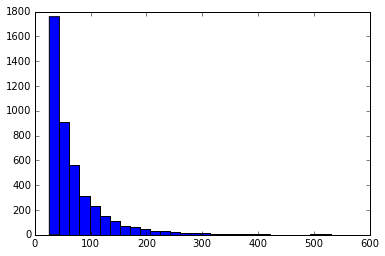

In [127]:
plt.hist(list_len, bins = 30)

In [132]:
def bread(func):
    def wrapper(word):
        print ("</------\>")
        func(word)
        print ("<\______/>")
    return wrapper

@bread
def breakfast(word):
    print(word)

In [25]:
np.concatenate((np.arange(5), np.ones(1)))

array([ 0.,  1.,  2.,  3.,  4.,  1.])

# старые эксперименты

In [17]:
a = np.arange(10)
b = a[1:4]
print(a)
print(b)
b[2] = 100
a[1] = -a[1]
print(a)
print(b)

[0 1 2 3 4 5 6 7 8 9]
[1 2 3]
[  0  -1   2 100   4   5   6   7   8   9]
[ -1   2 100]


In [70]:
tmp = mmread("../datasets/epinions_original/EP25_UPL5_test.mtx")
test = np.array(list(zip(tmp.row, tmp.col)))
tmp = mmread("../datasets/epinions_original/EP25_UPL5_train.mtx")
train = np.array(list(zip(tmp.row, tmp.col)))
user_item = [max(np.max(test[:,0]), np.max(train[:, 0])) + 1, max(np.max(test[:,1]), np.max(train[:,1])) + 1]

In [71]:
train = create_listarray(train)
test  = create_listarray(test)

In [ ]:
create_csr(train, user_item, '../pyCLiMF-master/good_train.pickle')
create_csr(test, user_item, '../pyCLiMF-master/good_test.pickle')

In [ ]:
randomrec = rankingmethod.RandomRec(user_item)
randomrec.fit(train)
all_measures(train, test, randomrec, False)

In [115]:
poprec = rankingmethod.PopRec(user_item)
poprec.fit(train)
top = poprec.get_list(0)[:3]
# all_measures(train, test, poprec, True, top)
# all_measures(train, test, poprec, True)

In [ ]:
rankingmeasure.get_AUC(train, test, poprec, True, K=user_item[1])

In [ ]:
rankingmeasure.get_NDCG(train, test, poprec, True, K = 5)

In [ ]:
rankingmeasure.get_NDCG(train, test, poprec, True, K = 3)

In [ ]:
index_user = np.random.choice(len(train), 100, replace=False)


In [ ]:
orig_train = create_original_sample(train, index_user)
orig_test = create_original_sample(test, index_user)

In [13]:
climf = rankingmethod.CLiMF(user_item, lrate = 0.0001, reg=0.001, maxiter=15, verbose=2)
climf.fit(train)

iteration 0 loss -98107.253456
iteration 1 loss -98106.9430412
iteration 2 loss -98106.6324012
iteration 3 loss -98106.3214964
iteration 4 loss -98106.0102875
iteration 5 loss -98105.698735
iteration 6 loss -98105.3867996
iteration 7 loss -98105.0744423
iteration 8 loss -98104.7616239
iteration 9 loss -98104.4483056
iteration 10 loss -98104.1344485
iteration 11 loss -98103.8200138
iteration 12 loss -98103.504963
iteration 13 loss -98103.1892575
iteration 14 loss -98102.872859


In [14]:
rankingmeasure.get_MRR(train, test, climf, True)

0.4036119383538297

In [119]:
all_measures(train, test, climf, True, top)

precision5 0.054217888936
1-call5 0.2337855023314964
MRR 0.1290192881946351


KeyboardInterrupt: 

In [117]:
all_measures(train, test, climf, True)

precision5 0.168334039847
1-call5 0.5370919881305638
MRR 0.4057593335701604
AUC 0.346615797654
NGDC 0.190403723158


In [ ]:
climf = rankingmethod.CLiMF(user_item, maxiter=40, lrate = 0.1, verbose=2)
climf.fit(train)


In [ ]:
all_measures(train, test, climf, False)

In [ ]:
all_measures(train, test, climf, True, top)

In [ ]:
list_reg = [0.001, 0.002, 0.005, 0.0005]
list_lrate = [0.05, 0.07, 0.1, 0.12, 0.15 ]
list_K = [10, 12, 15, 7, 5]
times_count = 3

for K, lrate, reg in itertools.product(list_K, list_lrate, list_reg):
    MRR = 0
    
    for t in range(times_count):
        climf = rankingmethod.CLiMF(user_item,K=K, reg=reg, lrate=lrate, verbose=0, maxiter=50)
        climf.fit(train)
        MRR += rankingmeasure.get_MRR(train, test, climf, skip_train=False)
    print("K", K, "lrate", lrate, "reg", reg, "MRR", MRR/times_count)
    sys.stdout.flush()

In [ ]:
bpr_mf = rankingmethod.BPR_MF(user_item, K = 20, lrate=0.001, regIpos=0.1, 
                              regIneg=0.1, regU=0.1, maxiter=30, verbose=2 )

In [ ]:
bpr_mf.fit(train)

In [ ]:
all_measures(train, test, bpr_mf, True)

In [ ]:
rankingmeasure.get_AUC(train, test, bpr_mf, True, K=user_item[1])

In [ ]:
rankingmeasure.get_NDCG(train, test, bpr_mf, True, K=5)

In [ ]:
imf = rankingmethod.iMF(user_item, K=20, lmbd=0.01, alpha=40, maxiter=30, verbose=2)

In [ ]:
imf.fit(train)

In [ ]:
all_measures(train, test, imf, True)

In [ ]:
all_measures(train, test, imf, True, top)

In [ ]:
all_measures(train, test, bpr_mf, True, top)

In [ ]:
all_measures(train, test, poprec, True)

In [ ]:
all_measures(train, test, poprec, True, top)

In [ ]:
from sklearn.metrics import roc_auc_score

In [ ]:
a = np.array([False,False, True, True])
b = np.array([0,2,1,3])
print(roc_auc_score(a, b, average=None))

In [ ]:
(a == True).any()

In [ ]:
import random

In [ ]:
random.sample(range(10), 3)